In [86]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [87]:
import numpy as np
import pandas as pd

In [88]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [89]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, select

In [90]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [91]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [92]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [93]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [94]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [95]:
print(Measurement.__table__.columns)

['measurement.id', 'measurement.station', 'measurement.date', 'measurement.prcp', 'measurement.tobs']


In [96]:
session.query(func.strftime("%Y-%m-%d",func.max(Measurement.date))).all()

[('2017-08-23')]

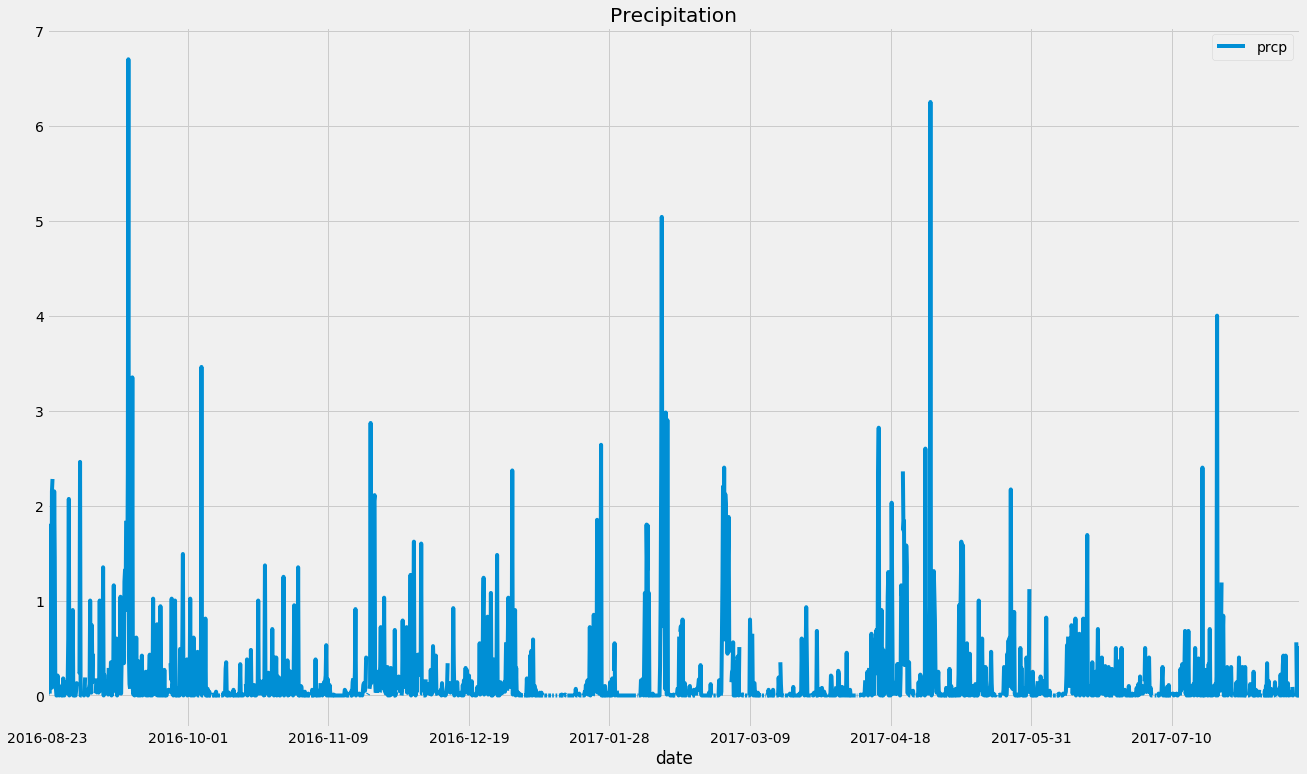

In [97]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
session.query(func.date(func.max(Measurement.date))).all()
# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= '2016-08-23').order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data)
prcp_df = prcp_df.set_index(prcp_df['date']).drop(columns=['date'])
# Sort the dataframe by date
# already sorted from query
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(figsize=(20,12),title='Precipitation')

![precipitation](Images/precipitation.png)

In [98]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [99]:
print(Station.__table__.columns)

['station.id', 'station.station', 'station.name', 'station.latitude', 'station.longitude', 'station.elevation']


In [100]:
# Design a query to show how many stations are available in this dataset?
session.query(func.Count(Station.name)).all()

[(9)]

In [101]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.Count(Measurement.prcp)).group_by(Measurement.station).order_by(func.Count(Measurement.prcp).desc()).all()

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [102]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.Min(Measurement.tobs),func.Max(Measurement.tobs),func.Round(func.Avg(Measurement.tobs),1)).filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.7)]

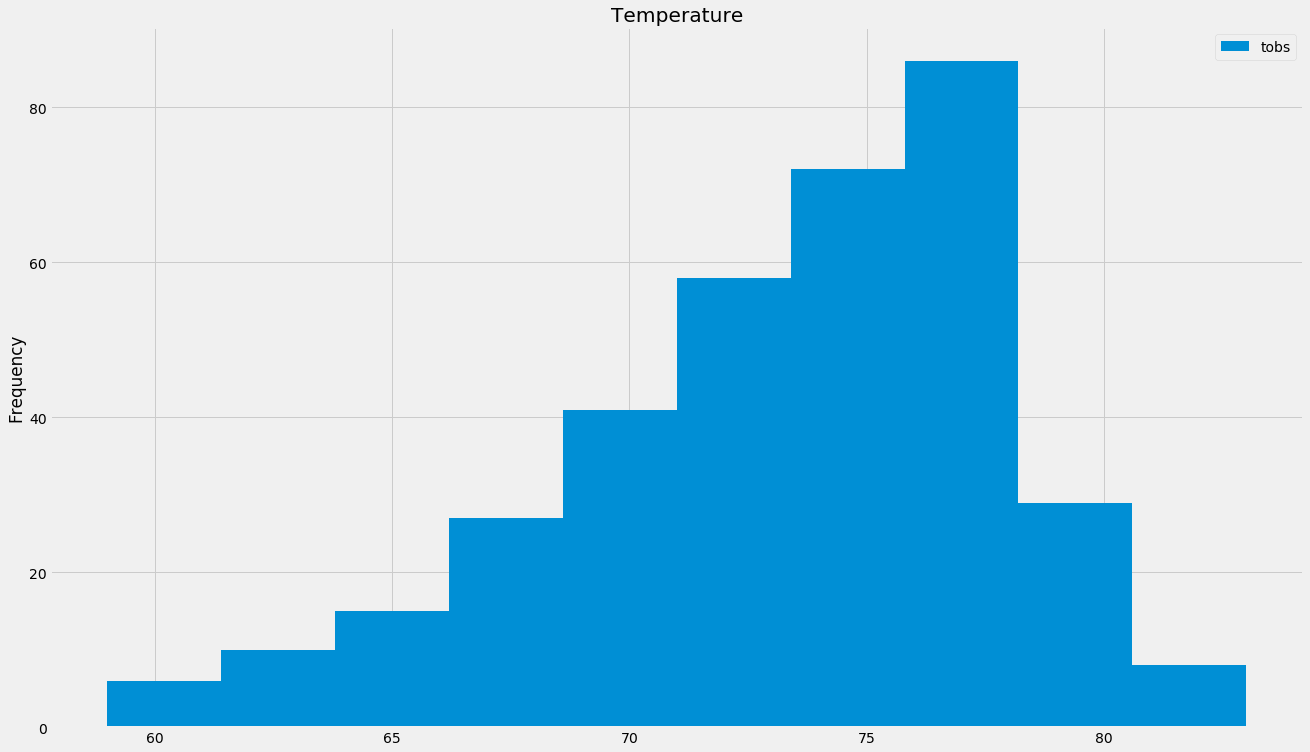

In [103]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.date,Measurement.tobs).filter(Measurement.date >= '2016-08-23').filter(Measurement.station == 'USC00519281').order_by(Measurement.date).all()
temp_df = pd.DataFrame(temp_data)
temp_df = temp_df.set_index(temp_df['date']).drop(columns=['date'])
temp_df.plot(kind='hist',figsize=(20,12),title='Temperature')

![precipitation](Images/station-histogram.png)

In [104]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    tmin = session.query(func.min(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()[0][0]
    tavg = session.query(func.Round(func.avg(Measurement.tobs),1)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()[0][0]
    tmax = session.query(func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()[0][0]
    return tmin,tavg,tmax
# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

(62.0, 69.6, 74.0)


In [105]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tmin,tavg,tmax = calc_temps('2017-05-21','2017-06-04')
yerr = (tmax - tmin)
x = 0
print(tmin,tavg,tmax)

69.0 76.2 87.0


Text(0.5, 1.0, 'Trip Average Temperature')

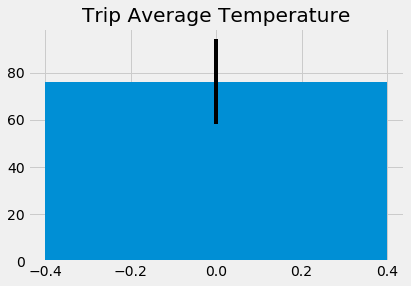

In [106]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar(x,tavg,yerr=yerr)
plt.title('Trip Average Temperature')

In [119]:
# This does not function
Measurement_subq = session.query(Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation).subquery()
total_rainfall = session.query(Measurement.station,func.Round(func.Sum(Measurement.prcp),2)).filter(Measurement.date >= '2017-05-21',Measurement.date <= '2017-06-04').group_by(Measurement.station).order_by(func.Round(func.Sum(Measurement.prcp),2).desc()).join(Measurement_subq,Measurement.station == Measurement_subq.c.station).all()

In [126]:
# Measurement_subq = session.query(Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation).subquery()
total_rainfall = session.query(Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.Round(func.Sum(Measurement.prcp),2)).filter(Measurement.date >= '2017-05-21',Measurement.date <= '2017-06-04').group_by(Measurement.station).order_by(func.Round(func.Sum(Measurement.prcp),2).desc()).filter(Measurement.station == Station.station).all()

In [132]:
total_rainfall

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  5.12),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  2.78),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 2.08),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  1.42),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.7),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.69),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.round(func.avg(Measurement.tobs),1), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
